In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir=r"Data/train/"
Retanial=[]
for file in os.listdir(data_dir):
    Retanial+=[file]
print(Retanial)
print(len(Retanial))

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
5


In [3]:
train_dir="Data/train"
val_dir="Data/val/"

In [4]:
img_height,img_width=256,256
batch_size=20

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

val_generator = train_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 506 images belonging to 5 classes.
Found 217 images belonging to 5 classes.


In [6]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [8]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [9]:
model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy",precision,recall])
hist=model.fit_generator(train_generator,epochs=20,validation_data=val_generator,verbose=1)

Epoch 1/20


C:\Users\ymts0427\AppData\Local\Temp\ipykernel_11616\3349351988.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=20,validation_data=val_generator,verbose=1)


26/26 [==============================] - 77s 3s/step - loss: 1.5702 - accuracy: 0.4328 - precision: 0.2892 - recall: 0.7075 - val_loss: 5.4382 - val_accuracy: 0.3733 - val_precision: 0.2140 - val_recall: 0.4378
Epoch 2/20
26/26 [==============================] - 68s 3s/step - loss: 0.9307 - accuracy: 0.6601 - precision: 0.3807 - recall: 0.9111 - val_loss: 6.2531 - val_accuracy: 0.3502 - val_precision: 0.2103 - val_recall: 0.5853
Epoch 3/20
26/26 [==============================] - 67s 3s/step - loss: 0.5526 - accuracy: 0.8103 - precision: 0.4235 - recall: 0.9684 - val_loss: 6.0200 - val_accuracy: 0.3641 - val_precision: 0.2148 - val_recall: 0.5899
Epoch 4/20
26/26 [==============================] - 69s 3s/step - loss: 0.2866 - accuracy: 0.9130 - precision: 0.4753 - recall: 0.9901 - val_loss: 3.4355 - val_accuracy: 0.2765 - val_precision: 0.2150 - val_recall: 0.5945
Epoch 5/20
26/26 [==============================] - 70s 3s/step - loss: 0.3691 - accuracy: 0.8715 - precision: 0.4779 - rec

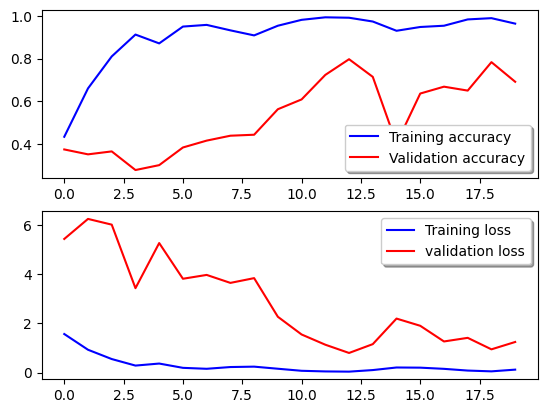

In [10]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

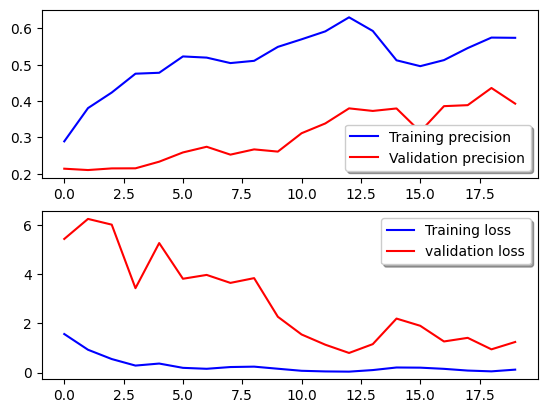

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

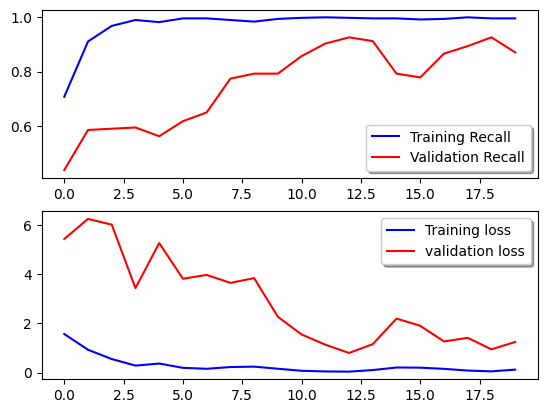

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training Recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation Recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [13]:
model.evaluate(val_generator)
model.save('model/Mobilenet.h5')

11/11 [==============================] - 5s 444ms/step - loss: 1.2468 - accuracy: 0.6912 - precision: 0.3929 - recall: 0.8710


In [14]:
filenames = val_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict_generator(val_generator,steps = nb_samples, verbose=2)

C:\Users\ymts0427\AppData\Local\Temp\ipykernel_11616\1843712888.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model_predict = model.predict_generator(val_generator,steps = nb_samples, verbose=2)


217/217 - 7s - 7s/epoch - 33ms/step


Confusion matrix, without normalization
[[ 4 12 20  1  2]
 [10 14 11  5  3]
 [ 3 18 16  5  6]
 [ 4 20 10  4  7]
 [ 6 15 14  5  2]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

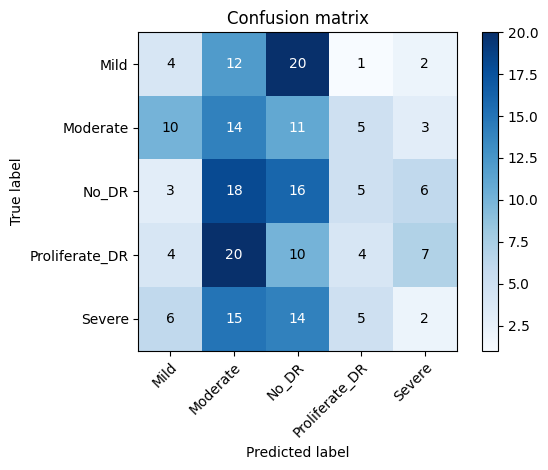

In [15]:
y_true = val_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe'],
                      title='Confusion matrix')

1/1 [==============================] - 1s 642ms/step
[0.43212843 0.98822874 0.7227787  0.02829447 0.13656297]


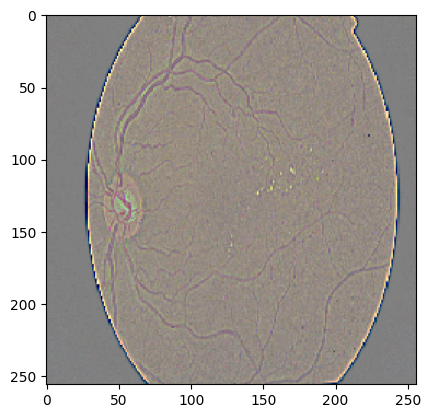

Prediction: Moderate


In [17]:
from skimage import io
from tensorflow.keras.preprocessing import image

img = image.load_img(r'Data\train\Moderate\0afdfe5f422c.png', grayscale=False, target_size=(img_height,img_width))
show_img=image.load_img(r'Data\train\Moderate\0afdfe5f422c.png', grayscale=False, target_size=(img_height,img_width))
Retanial = Retanial
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Retanial[ind])